<a href="https://colab.research.google.com/github/ianakoto/Cropland-Mapping/blob/main/Modelling_Creation_GEO_AI_Challenge_for_Cropland_Mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning with Earth Engine - Supervised Classification for  Cropland Mapping In Iran, Sudan and Afghanistan( Province)


This project is broken into the following notebooks:

- **Open 🧭 Overview**: Go through what we want to achieve, and explore the data we want to use as inputs and outputs for our model.

- **Open 🗄️ Create the dataset**: Use Apache Beam to fetch data from Earth Engine in parallel, and create a dataset for our model in Dataflow.

- **Open 🧠 Train the model**: Build and Test Various Supervised Classification Model using Earth engine.

- **Open 🔮 Model predictions**: Get predictions from the model with data it has never seen before.

This sample leverages geospatial satellite data from Google Earth Engine. Using satellite imagery, you'll build and train a model for Cropland classification

## Supervised classification algorithms available in Earth Engine

Source: https://developers.google.com/earth-engine/classification

source: https://openmrv.org/web/guest/w/modules/mrv/modules_1/land-cover-and-land-use-classification-in-google-earth-engine

The Classifier package handles supervised classification by traditional ML algorithms running in Earth Engine. These classifiers include **CART, RandomForest, DecisionForest and SVM**. The general workflow for classification is:

- Collect training data.

- Assemble features which have a property that stores the known class label and properties storing numeric values for the predictors.

- Instantiate a classifier. Set its parameters if necessary.

- Train the classifier using the training data.

- Classify an image or feature collection.

- Estimate classification error with independent validation data.

# 🎬 Before you begin

Let's start by cloning the GitHub repository, and installing some dependencies.

In [1]:
!rm -r /content/Cropland-Mapping

In [2]:
# Now let's get the code from GitHub and navigate to the sample.
!git clone https://github.com/ianakoto/Cropland-Mapping.git
%cd Cropland-Mapping/serving

Cloning into 'Cropland-Mapping'...
remote: Enumerating objects: 510, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 510 (delta 4), reused 0 (delta 0), pack-reused 494
Receiving objects: 100% (510/510), 1.77 MiB | 8.66 MiB/s, done.
Resolving deltas: 100% (273/273), done.
/content/Cropland-Mapping/serving


In [ ]:
#!pip install -q earthengine-api


In [3]:
%cd /content/Cropland-Mapping/serving

/content/Cropland-Mapping/serving


Install custom the package

In [4]:
# Install the custom package
!pip install -q dist/croplandclassification-0.0.1.tar.gz

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## ☁️ My Google Cloud resources

Make sure you have followed these steps to configure your Google Cloud project:

1. Enable the APIs: _Earth Engine_

  <button>

  [Click here to enable the APIs](https://console.cloud.google.com/flows/enableapi?apiid=earthengine.googleapis.com)
  </button>

1. Register your
  [Compute Engine default service account](https://console.cloud.google.com/iam-admin/iam)
  on Earth Engine.

  <button>

  [Click here to register your service account on Earth Engine](https://signup.earthengine.google.com/#!/service_accounts)
  </button>

Once you have everything ready, you can go ahead and fill in your Google Cloud resources in the following code cell.
Make sure you run it!

### ✏️ Enter your Cloud project's details. Ensure you provide a regional bucket!

In [5]:
from __future__ import annotations

import os
from google.colab import auth

# Please fill in these values.
project = "kagglex-396821"  # @param {type:"string"}
bucket = "cropland_classification_data"  # @param {type:"string"}
location = "us (multiple regions in United States)"  # @param {type:"string"}

# Quick input validations.
assert project, "⚠️ Please provide a Google Cloud project ID"
assert bucket, "⚠️ Please provide a Cloud Storage bucket name"
assert not bucket.startswith(
    "gs://"
), f"⚠️ Please remove the gs:// prefix from the bucket name: {bucket}"
assert location, "⚠️ Please provide a Google Cloud location"

# Authenticate to Colab.
auth.authenticate_user()

# Set GOOGLE_CLOUD_PROJECT for google.auth.default().
os.environ["GOOGLE_CLOUD_PROJECT"] = project

# Set the gcloud project for other gcloud commands.
!gcloud config set project {project}

Updated property [core/project].


## Import Earth Engine API and authenticate<a class="anchor" id="import-api"></a>

The Earth Engine API is installed by default in Google Colaboratory so requires only importing and authenticating. These steps must be completed for each new Colab session, if you restart your Colab kernel, or if your Colab virtual machine is recycled due to inactivity.

### Import the API

Run the following cell to import the API into your session.

In [6]:
import ee
import geemap
import os
import sys
import io
from io import StringIO
from datetime import datetime, timedelta
import pandas as pd
import random
import numpy as np
from google.cloud import storage

### Authenticate and initialize

Run the `ee.Authenticate` function to authenticate your access to Earth Engine servers and `ee.Initialize` to initialize it. Upon running the following cell you'll be asked to grant Earth Engine access to your Google account. Follow the instructions printed to the cell.

In [7]:
## Trigger the authentication flow. You only need to do this once
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=dWZPYcI6_7fVwHAbpfQINRgMHalOcQ_KUrS0DlaNhis&tc=4P0_ajzOltSlPMBi_dfJUTt16vb9nrwWjbr1ESB_Vx8&cc=RYb-hFJyj-czQDba45QHb7Z7bgA6T0cxOz1-QDeJvRE

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXn2pI7BcS7S-cT6cmxzd4pXlOhOvbCxFvmCBbvDjDY13xwMJzZCmUM

Successfully saved authorization token.


**Make Sure to Authenticate to Earth Engine Before running the below**

Import my custom library for this project

In [8]:
from croplandclassification.data import *
from croplandclassification.config import LABEL, BANDS, FEATURES
from croplandclassification.modeling import *

## Load Dataset From GCP

In [ ]:
def load_gcs_csv_to_dataframe(bucket_name, file_path):
    client = storage.Client()
    bucket = client.bucket(bucket_name)

    # Load the CSV file into a blob
    blob = bucket.blob(file_path)
    content = blob.download_as_text()

    # Read the CSV content into a DataFrame
    df = pd.read_csv(StringIO(content))
    return df

In [ ]:
# Load the CSV file into a DataFrame
df = load_gcs_csv_to_dataframe(bucket, "croplandclassification/training.csv")

In [ ]:
df.head()

,ID,Lat,Lon,Target
0,ID_SJ098E7S2SY9,34.162491,70.763668,0
1,ID_CWCD60FGJJYY,32.075695,48.492047,0
2,ID_R1XF70RMVGL3,14.542826,33.313483,1
3,ID_0ZBIDY0PEBVO,14.359480,33.284108,1
4,ID_C20R2C0AYIT0,14.419128,33.528450,0


Save and download the dataset

In [ ]:
df.to_csv("/content/training_data.csv", index=False)

## Create an interactive map and displaying Images

In [ ]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

Visualize one of the collections

Load the Image collections for the various regions of interest

In [ ]:
iran_collection, sudan_collection, afghanistan_collection = get_regions_collections()

merge all the collection for the classification task

In [ ]:
# Merge the collections
merged_collection = iran_collection.merge(sudan_collection).merge(afghanistan_collection)

In [ ]:
# get the properties of the collection

# Get the first image from the collection
first_image = iran_collection.first()

# Get band names and properties from the first image
band_names = first_image.bandNames()
band_properties = first_image.propertyNames()

# Print band names and properties
print('Band names:', band_names.getInfo())
print('Band properties:', band_properties.getInfo())

Band names: ['B2', 'B3', 'B4', 'B8', 'NDVI', 'NDWI', 'EVI']
Band properties: ['system:index', 'system:bands', 'system:band_names']


In [ ]:
iran_collection.select(["NDWI"]).mean().getInfo()

{'type': 'Image',
 'bands': [{'id': 'NDWI',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': -1,
    'max': 1},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

In [ ]:
image = iran_collection.select(["NDVI"]).mean()

vis_params = {'min': -1, 'max': 1,  'palette': ['#e5f5f9','#99d8c9','#2ca25f']}

# Create a Map
Map = geemap.Map()

# Add the FeatureCollection to the map
Map.addLayer(image.clip(iran_geometry), vis_params, "Sentinel 2 NDVI image for iran")
Map.centerObject(iran_geometry, 5)
# Display the map
Map


Map(center=[32.682876697170286, 54.37130922314299], controls=(WidgetControl(options=['position', 'transparent_…

## Create New Feature Collection in Earth Engine using the table in Earth engine assets.

- First download the training data
- Go to earth engine console
- Create a feature collection asset from the training data and make it sharable.

You can use mine below by the way

soruce1: https://developers.google.com/earth-engine/guides/table_upload

source2: https://open-mrv.readthedocs.io/en/latest/Tenneson_TrainingData_GEE.html

Load the Feature Collection and Display

In [9]:
table = ee.FeatureCollection("users/iancecilakoto/cropland_training_feature_points")

In [10]:
table.first().propertyNames().getInfo()

['Target', 'system:index', 'ID']

In [11]:
# Create a Map
Map = geemap.Map()

# Add the FeatureCollection to the map
Map.addLayer(table, {}, "Training Feature Collection")
Map.centerObject(table, 4)
# Display the map
Map


Map(center=[26.481781162634473, 45.05307876174318], controls=(WidgetControl(options=['position', 'transparent_…

After Testing the Feature Collection for training. I realized that the features are too large and am getting user memory exceeded.  Here i am trying to reduce the feature Collection and Try again with the classification.

After Experimenting i found that 100 - 170 samples per class is great. But you can also adjust it

In [12]:
final_sampled_features = sample_features_by_class(table, 170)

Final sampled FeatureCollection size: 340


Display the final features for Training

In [13]:
# Create a Map
Map = geemap.Map()

# Add the FeatureCollection to the map
Map.addLayer(final_sampled_features, {}, "Training Feature Collection")
Map.centerObject(table, 4)
# Display the map
Map


Map(center=[26.481781162634473, 45.05307876174318], controls=(WidgetControl(options=['position', 'transparent_…

# Supervised Classification

We are going to use the feature table to conduct a supervised classification over the collection of regions, iran, sudan and afghanistant( Province)

We will explore the following ML Models

- RandomForest

- Cart

- Gradient Boosting

- Maybe Minimum Distance CLassifier

- SVM

- e.t.c

In [ ]:
# get the properties of the collection

# Get the first image from the collection
first_image = merged_collection.first()

# Get band names and properties from the first image
band_names = first_image.bandNames()
band_properties = first_image.propertyNames()

# Print band names and properties
print('Band names:', band_names.getInfo())
print('Band properties:', band_properties.getInfo())

Band names: ['B2', 'B3', 'B4', 'B8', 'NDVI', 'NDWI', 'EVI']
Band properties: ['system:index', 'system:bands', 'system:band_names']


## RandomForest

After using random forest to get feature importance, the following bands or features were selected for training. It proved that NDWI, NDVI, B2 and EVI gave best results on all models averagely.

In [14]:
TRAIN_FEATURES = ["NDWI", "NDVI", "B2", "EVI"]

In [15]:
iran_collection, sudan_collection, afghanistan_collection = get_regions_collections()

In [16]:
merged_collection = iran_collection.merge(sudan_collection).merge(afghanistan_collection)

In [17]:
# This property of the table stores the cropland labels.
y = 'Target'

In [18]:
train_images = merged_collection.select(TRAIN_FEATURES).mosaic()

In [19]:
# Prepare the training data
training = train_images.sampleRegions(
    collection=final_sampled_features,
    properties=[y],  # Target property indicating cropland (1) or not (0)
    scale=10 # Specify the scale for sampling
)

In [20]:
# Adds a column of deterministic pseudorandom numbers.
sample = training.randomColumn()
#Split the data to train and test sets
split = 0.8

X_train = sample.filter(ee.Filter.lt('random', split)) #lt = less than
X_test = sample.filter(ee.Filter.gte('random', split)) #gte = greater than

The smileRandomForest algorithm accepts as its argument the number of trees to build -- here we chose between 50 , 250, and 350. Although the optimal number of trees varies in every situation, experience suggests that at least between 50 to 350 trees is a good target. THis is a trade-off between the number of training data points and the number of trees.

In [21]:
# Train  classifier:
smileRandomForest_train = ee.Classifier.smileRandomForest(numberOfTrees=250).train(features=X_train,
                                                                                  classProperty=y,
                                                                                  inputProperties= TRAIN_FEATURES)

#

In [22]:
# Classify the image with the same bands used for training.
smileRandomForest_train_image = train_images.select(TRAIN_FEATURES).classify(classifier  = smileRandomForest_train,
                                                                               outputName='cropland_classification')


In [23]:
# # Display the clusters with random colors.

Map = geemap.Map()
Map.addLayer(smileRandomForest_train_image.randomVisualizer(), {}, 'rf classified cropland')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

## Accuracy Assessment

- confusionMatrix() and Overall Accuracy:

    classifier.confusionMatrix() computes a confusion matrix for training data.
    Overall accuracy is the proportion of correctly classified reference sites.

- train_accuracy.accuracy():

    train_accuracy.accuracy().getInfo() provides the overall accuracy in percentage.

- Kappa Coefficient:

    Evaluates classification accuracy compared to random assignment (range: -1 to 1).

train_accuracy.kappa():

    train_accuracy.kappa().getInfo() retrieves the Kappa Coefficient.

- Producer's Accuracy:

    Measures how often real features on the ground are correctly shown on the map.

- train_accuracy.producersAccuracy():

    train_accuracy.producersAccuracy().getInfo() retrieves the Producer's Accuracy.

- Consumer's Accuracy:

    Measures how often the class on the map is actually present on the ground (reliability).
    
These metrics are crucial for assessing the accuracy of a classification model and understanding the performance from different perspectives: map maker (producer) and map user (consumer).







source https://geemap.org/notebooks/33_accuracy_assessment/#training-dataset

## Random Forest Classifier Accuracy Assessment

FOr this part we performed the feature Importance to get bands that we should focus on.

You can skip this part and continue as the bands have been select above

{'B2': 29.381947375285844, 'B3': 24.681297353288315, 'B4': 27.42674986795881, 'B8': 23.58782943821995, 'EVI': 29.989922743736873, 'NDVI': 24.15288315501754, 'NDWI': 26.922620860045182}


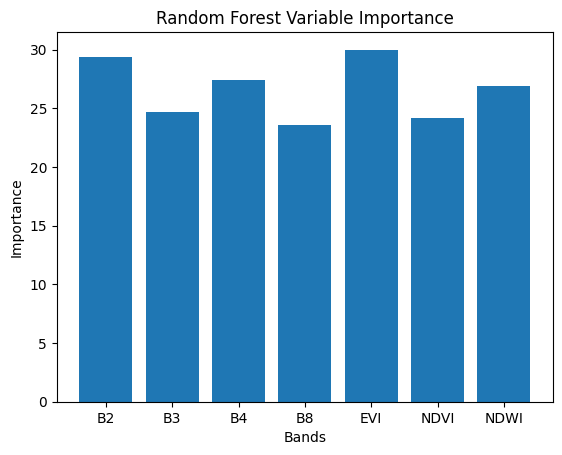

In [ ]:
import matplotlib.pyplot as plt

# Get the variable importance
variable_importance = smileRandomForest_train.explain().get('importance')

# Convert the variable importance to a client-side list
variable_importance_dict = variable_importance.getInfo()
print(variable_importance_dict)
# Get the band names (replace with your actual band names)
band_names = BANDS + FEATURES  # Replace with actual band names

# Plot the variable importance
# Extract bands and importances
ee_variable_importance = ee.Dictionary(variable_importance_dict)

# Extract bands and importances
bands = ee_variable_importance.keys().getInfo()
importances = ee_variable_importance.values().getInfo()

# Plot the variable importance
plt.bar(range(len(bands)), importances)
plt.xlabel('Bands')
plt.ylabel('Importance')
plt.title('Random Forest Variable Importance')
plt.xticks(range(len(bands)), bands)
plt.show()

feature importances
For the feature Importance we see that NDWI, B2, B4, and EVI play a major contribution. Let's try training the model with only these features and see

In [24]:
train_accuracy = smileRandomForest_train.confusionMatrix()

In [25]:
print(f"Confusion matrix: \n {train_accuracy.getInfo()}")
print(f"Consumers Accuracy: \n {train_accuracy.consumersAccuracy().getInfo()}")
print(f"Accuracy of classifier: \n  {train_accuracy.accuracy().getInfo()}")
print(f"Kappa of classifier: \n {train_accuracy.kappa().getInfo()}")
print(f"Producer's Accuracy: \n {train_accuracy.producersAccuracy().getInfo()}")

Confusion matrix: 
 [[138, 0], [2, 130]]
Consumers Accuracy: 
 [[0.9857142857142858, 1]]
Accuracy of classifier: 
  0.9925925925925926
Kappa of classifier: 
 0.977496839443742
Producer's Accuracy: 
 [[0.9927536231884058], [0.9844961240310077]]


Now Validate against Test Data

In [26]:
validated = X_test.classify(smileRandomForest_train)

In [27]:
validated.first().getInfo()

{'type': 'Feature',
 'geometry': None,
 'id': '1_00000000000000001236_0',
 'properties': {'B2': 0.12559999525547028,
  'EVI': 0.04357059152818261,
  'NDVI': 0.06093189865350723,
  'NDWI': -0.1584077924489975,
  'Target': 1,
  'classification': 0,
  'random': 0.8787231972740486}}

In [28]:
test_accuracy = validated.errorMatrix('Target', 'classification')
print(f"Confusion matrix: \n {test_accuracy.getInfo()}")
print(f"Consumers Accuracy: \n {train_accuracy.consumersAccuracy().getInfo()}")
print(f"Accuracy of classifier: \n  {test_accuracy.accuracy().getInfo()}")
print(f"Kappa of classifier: \n {test_accuracy.kappa().getInfo()}")
print(f"Producer's Accuracy: \n {test_accuracy.producersAccuracy().getInfo()}")

Confusion matrix: 
 [[17, 15], [18, 23]]
Consumers Accuracy: 
 [[0.9856115107913669, 0.9921875]]
Accuracy of classifier: 
  0.547945205479452
Kappa of classifier: 
 0.09128630705394178
Producer's Accuracy: 
 [[0.53125], [0.5609756097560976]]


As we can see, the Random Forest classifier is Over Fitting. We than Add more training points

## Cart Classification

In [ ]:
TRAIN_FEATURES = ["NDWI", "NDVI", "B2", "EVI"]

merged_collection = iran_collection.merge(sudan_collection).merge(afghanistan_collection)

# This property of the table stores the cropland labels.
y = 'Target'

train_images = merged_collection.select(TRAIN_FEATURES).max()

# Prepare the training data
training = train_images.sampleRegions(
    collection=final_sampled_features,
    properties=[y],  # Target property indicating cropland (1) or not (0)
    scale=10 # Specify the scale for sampling
)

# Adds a column of deterministic pseudorandom numbers.
sample = training.randomColumn()
#Split the data to train and test sets
split = 0.8

X_train = sample.filter(ee.Filter.lt('random', split)) #lt = less than
X_test = sample.filter(ee.Filter.gte('random', split)) #gte = greater than

# Adds a column of deterministic pseudorandom numbers.
sample = training.randomColumn()
#Split the data to train and test sets
split = 0.8

X_train = sample.filter(ee.Filter.lt('random', split)) #lt = less than
X_test = sample.filter(ee.Filter.gte('random', split)) #gte = greater than

# Train  classifier:
smileCart_train = ee.Classifier.smileCart().train(features=X_train,
                                                  classProperty=y,
                                                inputProperties= TRAIN_FEATURES)

#

# Classify the image with the same bands used for training.
smileCart_train_image = train_images.select(TRAIN_FEATURES).classify(classifier= smileCart_train,
                                                                    outputName='cropland_classification')



Display Cart Classification of cropland

In [ ]:
# # Display the clusters with random colors.

Map = geemap.Map()
Map.addLayer(smileCart_train_image.randomVisualizer(), {}, 'rf classified cropland')
Map


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

## Accuracy Assessment of Cart Model

In [ ]:


train_accuracy = smileCart_train.confusionMatrix()

print(f"Confusion matrix: \n {train_accuracy.getInfo()}")
print(f"Consumers Accuracy: \n {train_accuracy.consumersAccuracy().getInfo()}")
print(f"Accuracy of classifier: \n  {train_accuracy.accuracy().getInfo()}")
print(f"Kappa of classifier: \n {train_accuracy.kappa().getInfo()}")
print(f"Producer's Accuracy: \n {train_accuracy.producersAccuracy().getInfo()}")



Confusion matrix: 
 [[119, 0], [0, 123]]
Consumers Accuracy: 
 [[1, 1]]
Accuracy of classifier: 
  1
Kappa of classifier: 
 1
Producer's Accuracy: 
 [[1], [1]]


Validate the model with text data

In [ ]:

validated = X_test.classify(smileCart_train)

validated.first().getInfo()

test_accuracy = validated.errorMatrix('Target', 'classification')
print(f"Confusion matrix: \n {test_accuracy.getInfo()}")
print(f"Consumers Accuracy: \n {train_accuracy.consumersAccuracy().getInfo()}")
print(f"Accuracy of classifier: \n  {test_accuracy.accuracy().getInfo()}")
print(f"Kappa of classifier: \n {test_accuracy.kappa().getInfo()}")
print(f"Producer's Accuracy: \n {test_accuracy.producersAccuracy().getInfo()}")

Confusion matrix: 
 [[17, 14], [8, 19]]
Consumers Accuracy: 
 [[1, 1]]
Accuracy of classifier: 
  0.6206896551724138
Kappa of classifier: 
 0.24852767962308606
Producer's Accuracy: 
 [[0.5483870967741935], [0.7037037037037037]]


Cart model is also overfitting on the train set. We should set the number of trees if it is overfitting and try again

## Gradient Boost Classification

In [ ]:
sample_per_class_type = 170
# Filter based on the "target" property (cropland or not cropland)
cropland_features = table.filter(ee.Filter.eq('Target', 1))
non_cropland_features = table.filter(ee.Filter.eq('Target', 0))

# Randomly sample points from each category
sampled_cropland = cropland_features.randomColumn().sort('random').limit(sample_per_class_type)
sampled_non_cropland = non_cropland_features.randomColumn().sort('random').limit(sample_per_class_type)

# Combine the sampled points into a single FeatureCollection
final_sampled_features = sampled_cropland.merge(sampled_non_cropland)

# Print the size of the final sampled FeatureCollection
print('Final sampled FeatureCollection size:', final_sampled_features.size().getInfo())

Final sampled FeatureCollection size: 240


Let's Train it on the features

In [ ]:
iran_collection, sudan_collection, afghanistan_collection = get_regions_collections()
TRAIN_FEATURES =  ["NDWI", "NDVI", "B2", "EVI"]

merged_collection = iran_collection.merge(sudan_collection).merge(afghanistan_collection)

# This property of the table stores the cropland labels.
y = 'Target'

train_images = merged_collection.select(TRAIN_FEATURES).max()

# Prepare the training data
training = train_images.sampleRegions(
    collection=final_sampled_features,
    properties=[y],  # Target property indicating cropland (1) or not (0)
    scale=10 # Specify the scale for sampling
)

# Adds a column of deterministic pseudorandom numbers.
sample = training.randomColumn()
#Split the data to train and test sets
split = 0.8

X_train = sample.filter(ee.Filter.lt('random', split)) #lt = less than
X_test = sample.filter(ee.Filter.gte('random', split)) #gte = greater than

# Adds a column of deterministic pseudorandom numbers.
sample = training.randomColumn()
#Split the data to train and test sets
split = 0.8

X_train = sample.filter(ee.Filter.lt('random', split)) #lt = less than
X_test = sample.filter(ee.Filter.gte('random', split)) #gte = greater than

# Train  classifier:
smileGradientTreeBoost_train = ee.Classifier.smileGradientTreeBoost(numberOfTrees=250).train(features=X_train,
                                                  classProperty=y,
                                                inputProperties= TRAIN_FEATURES)

#

# Classify the image with the same bands used for training.
smileGradientTreeBoost_train_image = train_images.select(TRAIN_FEATURES).classify(classifier= smileGradientTreeBoost_train,
                                                                    outputName='cropland_classification')


Display OutPut

In [ ]:
# # Display the clusters with random colors.

Map = geemap.Map()
Map.addLayer(smileGradientTreeBoost_train_image.randomVisualizer(), {}, 'rf classified cropland')
Map


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

## Accuracy Assessment of GBOOST

In [ ]:

train_accuracy = smileGradientTreeBoost_train.confusionMatrix()

print(f"Confusion matrix: \n {train_accuracy.getInfo()}")
print(f"Consumers Accuracy: \n {train_accuracy.consumersAccuracy().getInfo()}")
print(f"Accuracy of classifier: \n  {train_accuracy.accuracy().getInfo()}")
print(f"Kappa of classifier: \n {train_accuracy.kappa().getInfo()}")
print(f"Producer's Accuracy: \n {train_accuracy.producersAccuracy().getInfo()}")

Confusion matrix: 
 [[93, 9], [7, 87]]
Consumers Accuracy: 
 [[0.93, 0.90625]]
Accuracy of classifier: 
  0.9183673469387755
Kappa of classifier: 
 0.8365985827428095
Producer's Accuracy: 
 [[0.9117647058823529], [0.925531914893617]]


Validate Classifier

In [ ]:
validated = X_test.classify(smileGradientTreeBoost_train)

validated.first().getInfo()

test_accuracy = validated.errorMatrix('Target', 'classification')
print(f"Confusion matrix: \n {test_accuracy.getInfo()}")
print(f"Consumers Accuracy: \n {train_accuracy.consumersAccuracy().getInfo()}")
print(f"Accuracy of classifier: \n  {test_accuracy.accuracy().getInfo()}")
print(f"Kappa of classifier: \n {test_accuracy.kappa().getInfo()}")
print(f"Producer's Accuracy: \n {test_accuracy.producersAccuracy().getInfo()}")

Confusion matrix: 
 [[11, 7], [10, 16]]
Consumers Accuracy: 
 [[0.93, 0.90625]]
Accuracy of classifier: 
  0.6136363636363636
Kappa of classifier: 
 0.22083333333333338
Producer's Accuracy: 
 [[0.6111111111111112], [0.6153846153846154]]


## Alternate Approach in Modelling


**So far i have seen that when i combine all the regions and classify on them it overfits. Also because the combined or mosaic regions area is very large, it leads to computation timeouts when adding additional training sample points.**


**There might be several reasons why the model is overfitting on the combined region datasets. But One is very certain: ->.**

**Because the 3 regions each have different spectral and temporal variations, it would be best apply a classification on each of the regions seperately, so as to achieve good accuracy on the test set**

Model Training for Each Region:

For each region (Iran, Sudan, Afghanistan), select the appropriate training data and Sentinel-2 imagery.
Train multiple classification models using Earth Engine. Common models include Gradient Tree Boosting, CART (Classification), and Random Forest.
Train each model using the training data, utilizing these important or few  features like NDWI, B2, B4, and EVI, and the corresponding cropland labels.

Earth engine has a max request to process data. so we will use few samples for the taining dataset to classify the regions.

source: A single query to Earth Engine is limited to 10MB in size. https://developers.google.com/earth-engine/guides/usage#:~:text=importing%20table%20data.-,Request%20payload%20size,been%20inlined%20into%20the%20query.



Encoding trees and Decoding trees for decisionTree Ensemble classification

source: https://gis.stackexchange.com/questions/443481/export-large-random-forest-decision-trees-to-asset-for-repeated-use-in-google-ea


Train For Each Region

In [29]:
final_sampled_features = sample_features_by_class(table,200)

Final sampled FeatureCollection size: 400


In [ ]:
# Get collections for each region
iran_collection, sudan_collection, afghanistan_collection = get_regions_collections()

# Dictionary to store classifiers for each region
classifiers = {}

# Iterate over each region
for region, region_collection in [("Iran", iran_collection),
                                  ("Sudan", sudan_collection),
                                   ("Afghanistan", afghanistan_collection)]:

    best_model_info = train_and_evaluate_models(region,
                                                region_collection,
                                                final_sampled_features)
    classifiers.update(best_model_info)

# Print the best model and its accuracy for each region
print("Best models and accuracies for each region:")
for region, model_info in classifiers.items():
    print(f"{region}: Best Model - {model_info['best_model_name']}, Test Accuracy - {model_info['best_accuracy']}")


Training and evaluating models for Iran...

Training data prepared.

Data split into training and testing sets.

Training Gradient Tree Boosting model...

Test accuracy for Gradient Tree Boosting: 0.7948717948717948

Gradient Tree Boosting model trained.

Training CART model...

Test accuracy for CART: 0.8205128205128205

CART model trained.

Training Random Forest model...

Test accuracy for Random Forest: 0.7948717948717948

Random Forest model trained.

Training Minimum Distance model...

Test accuracy for Minimum Distance: 0.7435897435897436

Minimum Distance model trained.

Training Naive Bayes model...

Test accuracy for Naive Bayes: 0.46153846153846156

Naive Bayes model trained.

Training SVM model...

Test accuracy for SVM: 0.717948717948718

SVM model trained.

Best model for Iran: CART, Test Accuracy: 0.8205128205128205

Training and evaluating models for Sudan...

Training data prepared.

Data split into training and testing sets.

Training Gradient Tree Boosting model...


## Save Models for later

In [ ]:
classifiers

{'Iran': {'best_model_name': 'Gradient Tree Boosting',
  'best_accuracy': 0.84,
  'best_model': <ee.Classifier at 0x7c0ee7687430>},
 'Sudan': {'best_model_name': 'Minimum Distance',
  'best_accuracy': 0.9642857142857143,
  'best_model': <ee.Classifier at 0x7c0ee744f370>},
 'Afghanistan': {'best_model_name': 'CART',
  'best_accuracy': 1,
  'best_model': <ee.Classifier at 0x7c0ee744f010>}}

In [ ]:
save_best_models(classifiers, '/content/best_models')

Now zip and download saved model for later use

In [ ]:
import zipfile
import os

def zip_folder(folder_path, output_path):
    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                zipf.write(os.path.join(root, file))

# Example usage
folder_to_zip = '/content/best_models'
output_zip_path = '/content/zip_folder.zip'

zip_folder(folder_to_zip, output_zip_path)

Download best models zip

In [ ]:
from google.colab import files

files.download(output_zip_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Load Model for prediction and deliverables

Make sure to upload the downloaded zip file to colab and unzip it with the following code. THen load the models with joblib

In [ ]:
!unzip /content/zip_folder.zip

In [ ]:
import joblib

iran_gradient_boost_classifier = joblib.load("")
sudan_minimum_distance_classifer = joblib.load("")
afghanistan_cart_classifier = joblib.load("")


## Prediction and SUbmission

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/Zindi Competitions/Cropland Classification/Test.csv")

In [ ]:
test_df.head()

,ID,Lat,Lon
0,ID_9ZLHTVF6NSU7,34.254835,70.348699
1,ID_LNN7BFCVEZKA,32.009669,48.535526
2,ID_SOYSG7W04UH3,14.431884,33.399991
3,ID_EAP7EXXV8ZDE,14.281866,33.441224
4,ID_QPRX1TUQVGHU,14.399365,33.109566


In [ ]:
classifiers = {
    "iran": iran_gradient_boost_classifier,
    "sudan": sudan_minimum_distance_classifer,
    "afghanistan": afghanistan_cart_classifier
}

In [ ]:
region_geometries = {
    "iran": iran_geometry,
    "sudan": sudan_geometry,
    "afghanistan": afghanistan_geometry
}

In [ ]:
image_collections = {
    "iran": iran_collection,
    "sudan": sudan_collection,
    "afghanistan": afghanistan_collection
}

In [ ]:
bands = ["NDWI", "NDVI", "B2", "EVI"]

Submission

In [ ]:
submission_df = classify_dataframe_with_regions(test_df,
                                                region_geometries,
                                                image_collections,
                                                classifiers,
                                                bands)